In [1]:
from fcgb.chatbots.chatbot import BaseChatBot
from fcgb.types.tools import ToolOutput
from langgraph.graph import MessagesState
from langchain_core.runnables.config import RunnableConfig
from langgraph.graph import StateGraph, START, END
from typing import List, Dict, Annotated
from pydantic import BaseModel

from operator import add
import uuid
from langchain_core.messages import ToolMessage
from langgraph.constants import Send
from fcgb.types.utils import append_or_clear, MessagesType
from fcgb.cfg.utils import model2string, dict2string

In [41]:
from fcgb.fake_models import FakeStructuredOutput
from fcgb.types.tools import JobModel

job_model = FakeStructuredOutput(JobModel)()
job_model, type(job_model)

(JobModel(job='Fake string ebxdn', restrictions='Fake string lndml', output_format='Fake string vxpwe', variables=['restrictions', 'restrictions', 'knowledge_base']),
 fcgb.types.tools.JobModel)

In [2]:

class PlannedIterativeTaskSolver(BaseChatBot):
    def __init__(self,
                 llm,
                 job_handler,
                 initial_messages_spec,
                 internal_messages_spec,
                 memory=None,
                 init_values={},
                 prompt_manager_spec={},
                 global_inputs={}):
        super().__init__(
            llm=llm,
            initial_messages_spec=initial_messages_spec,
            internal_messages_spec=internal_messages_spec,
            memory=memory,
            init_values=init_values,
            prompt_manager_spec=prompt_manager_spec,
            global_inputs=global_inputs,
            compile=False
        )

        self.job_handler = job_handler
        self.compile_graph()

    def _set_state_class(self):
        
        class State(BaseModel):
            template_inputs: Dict[str, str]
            all_messages: MessagesType
            current_messages: MessagesType
            all_jobs: Annotated[List, append_or_clear]
            current_jobs: List = []
            current_jobs_outputs: Annotated[List[str], append_or_clear]
            knowledge_base: str
            turns: int
            thread_id: str = None
            output: str = None # type: ignore

        self.state_class = State

    @staticmethod
    def _get_jobs_list(jobs_descriptions: List) -> str:
        return '\n'.join(f'Job {i+1}: {job.job}' for i, job in enumerate(jobs_descriptions))

    def _set_planning_func(self):

        def planning(state: self.state_class): # type: ignore
            turns = state.turns + 1
            print(f'Planning turn {turns}...')
            all_jobs = self._get_jobs_list(state.all_jobs)
            template_inputs = state.template_inputs | {'turns': turns, 'knowledge_base': state.knowledge_base, 'all_jobs': all_jobs}

            system_msg, _ = self._get_internal_message('system', template_inputs)
            query_msg, _ = self._get_internal_message('query', template_inputs)
            planning_msg, _ = self._get_internal_message('planning', template_inputs)

            plan_msg = self.llm.invoke([system_msg, query_msg, planning_msg])

            return {
                'current_messages': [system_msg, query_msg, planning_msg, plan_msg], 
                'turns': turns
                }
        
        return planning
    
    def _set_process_end_routing_func(self):

        def process_end_routing(state: self.state_class): # type: ignore

            if state.turns == 1:
                return 'distribution'
            elif state.turns >  self.global_inputs['max_turns']:
                return 'report'
            else:
                print(f'Process End Routing turn {state.turns}...')
                routing_msg, answer_model = self._get_internal_message('process_end_routing', state.template_inputs)

                decision = self.llm.with_structured_output(answer_model).invoke(state.current_messages + [routing_msg]).decision

                if decision == 'report':
                    return 'report'
                else:
                    return 'distribution'
                
        def max_turns_routing(state: self.state_class): # type: ignore
            return 'report' if state.turns >= self.global_inputs['max_turns'] else 'planning'
                
            
        return process_end_routing, max_turns_routing
    
    def _set_distribution_func(self):

        def distribution(state: self.state_class): # type: ignore
            print(f'Jobs Distribution turn {state.turns}...')

            template_inputs = state.template_inputs | {'turns': state.turns, 'knowledge_base': state.knowledge_base}

            distribution_msg, answer_model = self._get_internal_message('distribution', template_inputs)

            jobs = self.llm.with_structured_output(answer_model).invoke(state.current_messages + [distribution_msg])

            return {
                'current_jobs': jobs.jobs
            }
        
        return distribution
    
    def _set_job_routing_func(self):

        def job_routing(state: self.state_class): # type: ignore

            return [Send('executor',  {'state': state, 'job': job}) for job in state.current_jobs]
        
        return job_routing
    
    def _set_executor_func(self):

        def executor(input: Dict): # type: ignore
            job = input['job']
            state = input['state']

            print(f'Job Execution turn {state.turns}: {job.job}...')

            job_dict = job.model_dump()
            variables = job_dict['variables']
            job_dict.pop('variables', None)  # Remove 'variables' key if it exists
            job_description = dict2string(job_dict)

            if len(variables) > 0:
                data_content = '\n\n# **additional data**:\n'
                variable_base = state.template_inputs | {'knowledge_base': state.knowledge_base}
                available_variables = variable_base.keys()
                for variable in variables:
                    if variable in available_variables:
                        data_content += f'## {variable}:\n{variable_base[variable]}\n\n'

                job_description += data_content
            
            job_output = self.job_handler.run(job_description=job_description)
            print(f'Job execution end')
            return {'current_jobs_outputs': job_output}
        
        return executor
    
    @staticmethod
    def concatenate_outputs(outputs: List[Dict]) -> str:
        return '\n-----\n'.join(output['output'] for output in outputs if 'output' in output)
    
    def _set_base_extension_func(self):

        def base_extension(state: self.state_class): # type: ignore
            print(f'Base Extension turn {state.turns}...')
            retrieved_data = self.concatenate_outputs(state.current_jobs_outputs)
            current_jobs = self._get_jobs_list(state.current_jobs)
            template_inputs = state.template_inputs | {'turns': state.turns, 'knowledge_base': state.knowledge_base, 'retrieved_data': retrieved_data, 'current_jobs': current_jobs}
            extension_msg, _ = self._get_internal_message('base_extension', template_inputs)

            extended_base = self.llm.invoke(state.current_messages + [extension_msg])
            return {
                'knowledge_base': extended_base.content,
                'current_messages': [extension_msg, extended_base],
            }
        
        return base_extension
    
    def _set_iteration_end_func(self):

        def iteration_end(state: self.state_class): # type: ignore
            messages_to_pass = state.current_messages[2:] if state.turns>1 else state.current_messages
            return {
                'all_messages': messages_to_pass,
                'current_messages': '__clear__',
                'all_jobs': state.current_jobs,
                'current_jobs': [],
                'current_jobs_outputs': '__clear__'
            }

        return iteration_end
    
    def _set_report_func(self):

        def report(state: self.state_class, config: RunnableConfig): # type: ignore
            print(f'Reporting turn {state.turns}...')
            template_inputs = state.template_inputs | {'turns': state.turns, 'knowledge_base': state.knowledge_base}

            report_msg, _ = self._get_internal_message('report', template_inputs)

            output = self.llm.invoke([report_msg])
            thread_id = config['configurable']['thread_id']

            return {
                'output': output.content,
                'thread_id': thread_id,
                'all_messages': state.current_messages[2:],
                'current_messages': '__clear__',
            }
        
        return report
    
    def _compile_graph(self):
        
        planning_func = self._set_planning_func()
        process_end_routing_func, max_turns_routing_func = self._set_process_end_routing_func()
        distribution_func = self._set_distribution_func()
        job_routing_func = self._set_job_routing_func()
        executor_func = self._set_executor_func()
        base_extension_func = self._set_base_extension_func()
        iteration_end_func = self._set_iteration_end_func()
        report_func = self._set_report_func()

        workflow = StateGraph(self.state_class)
        workflow.add_node('planning', planning_func)
        workflow.add_node('distribution', distribution_func)
        workflow.add_node('executor', executor_func)
        workflow.add_node('base_extension', base_extension_func)
        workflow.add_node('iteration_end', iteration_end_func)
        workflow.add_node('report', report_func)

        workflow.add_edge(START, 'planning')
        workflow.add_conditional_edges('planning', process_end_routing_func, ['distribution', 'report'])
        workflow.add_conditional_edges('distribution', job_routing_func, ['executor'])
        workflow.add_edge('executor', 'base_extension')
        workflow.add_edge('base_extension', 'iteration_end')
        workflow.add_conditional_edges('iteration_end', max_turns_routing_func, ['planning', 'report'])
        workflow.add_edge('report', END)

        self.graph = workflow.compile(
            checkpointer=self.memory
        )

    def run(self, job: str, restrictions: str, output_format: str, data: str) -> ToolOutput:
        
        thread_id = uuid.uuid4().hex
        return self.graph.invoke(
            input={
                'template_inputs': {
                    'job': job,
                    'restrictions': restrictions,
                    'output_format': output_format,
                    'data': data
                    },
                'turns': 0,
                'knowledge_base': 'Empty'
                },
            config = {'configurable': {'thread_id': thread_id}},
            output_keys=['thread_id', 'output']
        )

In [3]:
inputs = {
    'job': 'List all Chain-of-Thought prompting variants',
    'restrictions': """
    1. List only real prompting techniques
    2. Do not include techniques that are just applications of other techniques
    3. Do not include techniques that are not related to CoT prompting""",
    'output_format': 'List of techniques with very short description of each technique',
    'data': 'None'
}

In [6]:
additional_data = """
**BOOK SPECIFICATION:**
{'main_title': 'About Prompt Engineering',
 'initial_description': 'Guide should cover widely concepts of prompt engineering, with focus on specific prompt engineering techniques and their variations, \ntry to cover as many of them as you can. Target audience is not defined, so potential readers would be as well non-technical as technical.\nEnrich every technique with examples. Write also something about how LLMs work, and how prompt engineering can help to improve their performance.',
 'main_subject': 'Mastering prompt engineering techniques: a comprehensive guide for all skill levels',
 'content_description': '*   Broad overview of prompt engineering techniques [essential]\n*   Comprehensive guide from beginner to expert [essential]\n*   Everything relevant to writing great and accurate prompts [essential]\n*   Detailed breakdown of techniques with multiple variations and real-world examples [essential]\n*   Information about how prompting may influence technical aspects of LLMs, covered within the introduction [moderate]\n*   Techniques for improving factual accuracy, controlling style/tone, eliciting creative content, reasoning/problem-solving, and generating different content formats [high]\n*   Detailed view of techniques like zero-shot prompting and chain-of-thought prompting [essential]\n*   Visual aids to augment every technique [essential]',
 'style': "*   Avoid industry-focused content [essential]\n*   Avoid overly formal language [essential]\n*   Humorous language is acceptable if it doesn't detract from credibility [moderate]",
 'target_audience': '*   Both non-technical and technical readers',
 'layout': '*   Full-length book (200+ pages) [essential]\n*   Detailed view includes: formal definition, explanation of why it works, multiple examples, limitations/drawbacks, and variations [essential]',
 'restrictions': ['*   No deep-dive into LLM architecture beyond the introduction [essential]']}
"""

inputs = {
    'job': 'You are constructing an initial level of a subjects tree-graph for a guide book defined in the additional_data section. Divide the main subject into up to 20 distinct subjects that will decompose the core ideas of the book.',
    'restrictions': """
    1. Use all information provided in the additional_data section
    """,
    'output_format': """
    List of sections with titles, descriptions and relevance (how it refers to the book specification) in format:
    Title: <title 1>
    - Description: <description 1>
    - Relevance: <relevance 1>
    Title: <title 2>
    - Description: <description 2>
    - Relevance: <relevance 2>
    ...
    """,
    'data': additional_data
}

# **TASK**
You are constructing a knowledge graph for a book: "About Prompt Engineering: Mastering prompt engineering techniques: a comprehensive guide for all skill levels".
Analyze current graph state and according to the provided book specification, knowledge graph rules and node types specification propose a list of up to 10 new knowledge graph nodes. 
Do not treat nodes from your answer as already existing nodes but rather as proposals. You can't refer to them as parent nodes in other nodes included in your answer.
Propose only nodes that fit to already existing graph state.

## **KNOWLEDGE GRAPH RULES**
- Knowledge graph is a collection of nodes connected with edges in a directed acyclic graph (DAG) structure where except the core node, each node can have multiple children nodes and only one parent node. 
- Each node should represent a single knowledge entity useful for the book structure planning. The are not suposed to be sections of the book.
- Build it from the core node which is the book title starting with the most general subjects and then gradually narrow down to more specific topics.
- Use container nodes to collect entities that represents the same category of knowledge.
- Concept nodes are usefull to gather knowledge about specific entities to plan further exploration, build analysis nodes or just explain unit topics.
- Analysis nodes should be used mainly to produce some inights of elements of some container node, collection of concept nodes or add some specific additional information to a single concept node.
- Avoid duplicating nodes, be sure you are not proposing nodes that already exist or explore the same areas at the same time.

## **NODE TYPES SPECIFICATION**
1. **container** 
- purpose: Node will be used just as a parent node to its list of outputs. It won't have its own content.
- research objective: Specify directly what kind of items are expected to be placed under this node. Do not specify what future child nodes should contain, just what they should be.
- examples: "ML classification techniques", "Flower species", "Programming languages"
2. **concept**
- purpose: Node will contain a concept, definition, or explanation of a specific term or idea. It can be still connected with some child nodes later.
- research objective: Specify what should be included in its content, such as definitions, explanations, and examples.
- examples: "Neural networks", "Photosynthesis", "Object-oriented programming"
3. **analysis**
- purpose: Node will contain an analysis of a specific topic, including comparisons, evaluations, or assessments. The role of this node is to provide extended insights into container or concept nodes.
- research objective: Specify the purpose of the analysis, such as comparing different approaches, evaluating effectiveness, assessing implications etc.. If your are able to at this point also write steps of reasoning.
- examples: "Comparison of ML algorithms", "Evaluation of renewable energy sources", "Limitations of JavaScript"
- **Constraint**: Analysis nodes should be based on existing concept nodes. Before using them make sure that concept nodes they are based on exist in the graph. For exaple, if you want to create an analysis node "Comparison of ML algorithms", make sure that there is some container with different nodes representing specific ML algorithms.

## **GRAPH STATE**
### **Nodes**
('id'=1, 'title'='About Prompt Engineering', 'type'='container', 'description'='Core node of a knowledge graph')

## **ANSWER FORMAT**
```
1. [Node Title 1]
    - Node type: [container/concept/analysis]
    - Research objective: [brief description of what should be included in the node according to the node type specification]
    - Purpose: [why it is relevant to the book specification]
    - Parent node id: [id of an existing node from the graph state]
2. [None Title 2]
...
```

---

# **BOOK SPECIFICATION**

## **Main title**
About Prompt Engineering

## **Subtitle**
Mastering prompt engineering techniques: a comprehensive guide for all skill levels

## **Book object description**
Guide should cover widely concepts of prompt engineering, with focus on specific prompt engineering techniques and their variations, try to cover as many of them as you can. Target audience is not defined, so potential readers would be as well non-technical as technical.\nEnrich every technique with examples. Write also something about how LLMs work, and how prompt engineering can help to improve their performance.

## **Content description**
* Broad overview of prompt engineering techniques [essential] 
* Comprehensive guide from beginner to expert [essential]
* Everything relevant to writing great and accurate prompts [essential]  
* Detailed breakdown of techniques with multiple variations and real-world examples [essential]
* Information about how prompting may influence technical aspects of LLMs, covered within the introduction [moderate]  
* Techniques for improving factual accuracy, controlling style/tone, eliciting creative content, reasoning/problem-solving, and generating different content formats [high]
* Detailed view of techniques like zero-shot prompting and chain-of-thought prompting [essential]
* Visual aids to augment every technique [essential]

## **Style**
* Avoid industry-focused content [essential] 
* Avoid overly formal language [essential]
* Humorous language is acceptable if it doesn't detract from credibility [moderate]

## **Layout**
* Full-length book (200+ pages) [essential]
* Detailed view includes: formal definition, explanation of why it works, multiple examples, limitations/drawbacks, and variations [essential]

## **Restrictions**
* No deep-dive into LLM architecture beyond the introduction.,
* Avoid sections focused on LLM usage for specific industries or professional fields (e.g., law, medicine, finance). Examples of techniques are allowed, but they should not be the primary focus.,
* Avoid including techniques that are actually LLM weights fine-tuning methods (as opposed to prompt engineering techniques).,
* Avoid sections heavily reliant on bullet points, code snippets, or examples. Aim for a balance that prioritizes descriptive explanations.,
* Prioritize practical, real-world examples from professional environments. Avoid simplistic or "toy" examples.,
* Explain advanced technical concepts in a simplified manner, focusing on how to use the prompting techniques rather than the underlying technical details of how they affect the model

## **Target audience**
Both non-technical and technical readers

# **TASK**
Your mission is to find Chain-of-Thought variants which will be added to the knowledge graph for a book described in the book specification.
Analyze the research assignment and if you are able to do it by yourself propose an answer in format:
```
* **item 1**: 
 - description: [brief description of the item]
 - relevance: [why it is relevant to the book specification and research assignment]
* **item 2**:
...
```


## **RESEARCH ASSIGNMENT**
Research objective: Collect comprehensive list of Chain-of-Thought prompting variations (like "Zero-shot CoT", "Few-shot CoT", "Self-consistency CoT") 
Purpose: As specified in the content description the book should include detailed breakdown of techniques with multiple variations. CoT seems to be one of the most important techniques, so it should be covered in detail.

# **BOOK SPECIFICATION**

## **Main title**
About Prompt Engineering

## **Subtitle**
Mastering prompt engineering techniques: a comprehensive guide for all skill levels

## **Book object description**
Guide should cover widely concepts of prompt engineering, with focus on specific prompt engineering techniques and their variations, try to cover as many of them as you can. Target audience is not defined, so potential readers would be as well non-technical as technical.\nEnrich every technique with examples. Write also something about how LLMs work, and how prompt engineering can help to improve their performance.

## **Content description**
* Broad overview of prompt engineering techniques [essential] 
* Comprehensive guide from beginner to expert [essential]
* Everything relevant to writing great and accurate prompts [essential]  
* Detailed breakdown of techniques with multiple variations and real-world examples [essential]
* Information about how prompting may influence technical aspects of LLMs, covered within the introduction [moderate]  
* Techniques for improving factual accuracy, controlling style/tone, eliciting creative content, reasoning/problem-solving, and generating different content formats [high]
* Detailed view of techniques like zero-shot prompting and chain-of-thought prompting [essential]
* Visual aids to augment every technique [essential]

## **Style**
* Avoid industry-focused content [essential] 
* Avoid overly formal language [essential]
* Humorous language is acceptable if it doesn't detract from credibility [moderate]

## **Layout**
* Full-length book (200+ pages) [essential]
* Detailed view includes: formal definition, explanation of why it works, multiple examples, limitations/drawbacks, and variations [essential]

## **Restrictions**
* No deep-dive into LLM architecture beyond the introduction.,
* Avoid sections focused on LLM usage for specific industries or professional fields (e.g., law, medicine, finance). Examples of techniques are allowed, but they should not be the primary focus.,
* Avoid including techniques that are actually LLM weights fine-tuning methods (as opposed to prompt engineering techniques).,
* Avoid sections heavily reliant on bullet points, code snippets, or examples. Aim for a balance that prioritizes descriptive explanations.,
* Prioritize practical, real-world examples from professional environments. Avoid simplistic or "toy" examples.,
* Explain advanced technical concepts in a simplified manner, focusing on how to use the prompting techniques rather than the underlying technical details of how they affect the model

## **Target audience**
Both non-technical and technical readers

Keeping in mind all provided specifications and current answer state propose a step-by-step strategy to expand the answer with more items.

Strategy example 1:
```
Research objective: Find all main ML algorithms.
Strategy:
1. Identify the main categories of ML algorithms (e.g., supervised learning, unsupervised learning, reinforcement learning).
2. For each category, list the most common algorithms (e.g., linear regression, decision trees, k-means clustering).
3. Collect items from each category.
```

Strategy example 2:
```
Research objective: How to stay calm in stressful situations.
Strategy:
1. Describe some stressful situation and how it affects people.
2. Identify how one can mitigate stress in such situation.
3. Find techniques that fits to the methods described in point 2.
```

Strategy example 3:
```
Research objective: Fundamentals of healthy diet. Speficy main concepts of healthy eating.
Strategy:
1. List few purposes of why people should eat healthy.
2. Specify how to address each purpose.
3. Aggregate purposes into distinct subjects.
```

Evaluate provided list in terms of how general or specific every subject is using the provided scale.
Return a list in following format:
([subject_title], [level_of_generality])

For example:
(Machine Learning, 2)
(Support Vector Machines, 4)

## **Level of Generality Scale**
### Level 1: Very Broad / Foundational

    Name: Macro-Topic
    Instruction: Assign this level if the subject represents a very high-level, overarching domain or discipline. It's likely to encompass numerous major sub-fields and could easily be the title of an entire textbook or university department. Further decomposition is absolutely necessary to make it actionable within a knowledge base.
    Example: "Artificial Intelligence," "Human Anatomy," "World History"

### Level 2: Broad / Major Area

    Name: Major Domain
    Instruction: Assign this level if the subject is a significant, well-defined area within a broader macro-topic. While more focused than Level 1, it still contains a considerable amount of information and would likely be broken down into several distinct sub-topics. Requires substantial further decomposition.
    Example: "Machine Learning" (within Artificial Intelligence), "Skeletal System" (within Human Anatomy), "World War II" (within World History)

### Level 3: Moderate / Specific Topic

    Name: Specific Topic
    Instruction: Assign this level if the subject is a distinct topic that can be reasonably covered in a dedicated chapter or significant section. It's specific enough that its boundaries are clear, but still likely to have a few key sub-areas or concepts that would be beneficial to explore individually. Further decomposition is often beneficial, but not always strictly necessary depending on the overall depth desired for the knowledge base.
    Example: "Supervised Learning Algorithms" (within Machine Learning), "Bone Fractures" (within Skeletal System), "The Battle of Stalingrad" (within World War II)

### Level 4: Detailed / Sub-Topic

    Name: Sub-Topic / Concept
    Instruction: Assign this level if the subject represents a clearly defined concept, method, or component within a more specific topic. It's getting close to a "leaf node" for many knowledge bases, though very granular details might still exist. Further decomposition might involve breaking down a process into steps, a concept into its defining attributes, or a component into its sub-components.
    Example: "Support Vector Machines" (within Supervised Learning Algorithms), "Types of Fractures" (within Bone Fractures), "German Strategy at Stalingrad" (within The Battle of Stalingrad)

### Level 5: Very Detailed / Atomic Unit

    Name: Atomic Detail / Granular Fact
    Instruction: Assign this level if the subject represents a highly specific piece of information, a single concept, a particular definition, or a very specific technique. It's unlikely to be further decomposed in a meaningful way for most knowledge bases, serving as a "leaf node" or a specific data point. It represents the smallest practical unit of information for the current scope.
    Example: "Kernel Trick in SVMs" (within Support Vector Machines), "Greenstick Fracture Definition" (within Types of Fractures), "Operation Uranus" (within German Strategy at Stalingrad)


Think of every research path as a node of knowledge graph for specified book. Add to every point of listed directions node classification using categories:

1. **container** 
- purpose: Node will be used just as a parent node to its list of outputs. It won't have its own content.
- research objective: Specify directly what kind of items are expected to be placed under this node. Do not specify what future child nodes should contain, just what they should be.
- examples: "ML classification techniques", "Flower species", "Programming languages"
2. **concept**
- purpose: Node will contain a concept, definition, or explanation of a specific term or idea. It can be still connected with some child nodes later.
- research objective: Specify what should be included in its content, such as definitions, explanations, and examples.
- examples: "Neural networks", "Photosynthesis", "Object-oriented programming"
3. **analysis**
- purpose: Node will contain an analysis of a specific topic, including comparisons, evaluations, or assessments. The role of this node is to provide extended insights into container or concept nodes.
- research objective: Specify the purpose of the analysis, such as comparing different approaches, evaluating effectiveness, assessing implications etc.. If your are able to at this point also write steps of reasoning.
- examples: "Comparison of ML algorithms", "Evaluation of renewable energy sources", "Limitations of JavaScript"

---

Rewrite your adding category to every research task and refine research objectives to fit description of assigned category.

In [3]:
inputs = {
    'job': 'Prepare a list of 6 to 8 potential chapters for a guide book on Prompt Engineering Techniques: from beginner to advanced',
    'restrictions': """
    1. The chapters should be suitable for a beginner to advanced audience
    2. Focus primarily on actual prompting techniques, not just general concepts
    3. Ignore any chapters that are just applications of those techniques
    """,
    'output_format': 'List of chapters with very short description of each chapter',
    'data': 'None'
}

In [4]:
from fcgb.cfg.precompiled import get_llm, get_checkpointer
from fcgb.tools.spectools import PhantomResearcherSpecTool, JobHandlerSpecTool, JobHandler
from fcgb.cfg.chat_inputs_spec import PlannedIterativeTaskSolverConfig

## Fake LLM

In [5]:
fake_llm = get_llm(llm_model='fake')
memory = get_checkpointer(checkpointer_mode='local', mode='test')

tool_containers = [
    PhantomResearcherSpecTool(llm=fake_llm, memory=memory)
]

job_handler = JobHandlerSpecTool(
    llm=fake_llm,
    tool_containers=tool_containers,
    memory=memory,
)

In [6]:
task_solver = PlannedIterativeTaskSolver(
    llm=fake_llm,
    job_handler=job_handler,
    initial_messages_spec=PlannedIterativeTaskSolverConfig.initial_messages_spec,
    internal_messages_spec=PlannedIterativeTaskSolverConfig.internal_messages_spec,
    memory=memory,
    init_values=PlannedIterativeTaskSolverConfig.init_values,
    prompt_manager_spec=PlannedIterativeTaskSolverConfig.prompt_manager_spec,
    global_inputs=PlannedIterativeTaskSolverConfig.global_inputs
)

In [10]:
output = task_solver.run(**inputs)

# Final Report
for line in output['output'].split('\n'):
    print(line)

Planning turn 1...
Jobs Distribution turn 1...
Job Execution turn 1: Fake string zoopt...
Job Execution turn 1: Fake string jcbhf...
Job Execution turn 1: Fake string bxnxx...
Job Execution turn 1: Fake string xxuzp...
Job execution end
Job execution end
Job execution end
Job execution end
Base Extension turn 1...
Planning turn 2...
Process End Routing turn 2...
Reporting turn 2...
Fake LLM response 51


In [12]:
# Load whole task solver state
research_state = task_solver.get_state(output['thread_id'])
research_state

{'template_inputs': {'job': 'List all Chain-of-Thought prompting variants',
  'restrictions': '\n    1. List only real prompting techniques\n    2. Do not include techniques that are just applications of other techniques\n    3. Do not include techniques that are not related to CoT prompting',
  'output_format': 'List of techniques with very short description of each technique',
  'data': 'None'},
 'turns': 4,
 'knowledge_base': 'Fake LLM response 138',
 'current_messages': [],
 'current_jobs': [],
 'current_jobs_outputs': [],
 'all_messages': [SystemMessage(content="# **CONVERSATION PURPOSE**\n\nThis conversation aims to:\n\n1.  **Acquire Data**: Systematically gather all data relevant to the research's **MAIN TASK**.\n2.  **Plan Strategically**: Conduct iterative research, moving from general to specific topics.\n3.  **Ensure Comprehensive Output**: Continuously analyze the **MAIN TASK** description to ensure all necessary data is collected.\n\n---\n\n# **WORKFLOW OVERVIEW**\n\n## **

In [9]:
# All messages from the process
for msg in research_state['all_messages']:
    msg.pretty_print()

================================ System Message ================================
Name: system

# **CONVERSATION PURPOSE**

This conversation aims to:

1.  **Acquire Data**: Systematically gather all data relevant to the research's **MAIN TASK**.
2.  **Plan Strategically**: Conduct iterative research, moving from general to specific topics.
3.  **Ensure Comprehensive Output**: Continuously analyze the **MAIN TASK** description to ensure all necessary data is collected.

---

# **WORKFLOW OVERVIEW**

## **Workflow nodes**
Each node has a specific role. Focus solely on the current node's task without anticipating subsequent steps.
- Task Specification: The user provides the main task description and all necessary details.
- Analysis: Assess the current knowledge base and formulate further research directions.
- Job Distribution: Based on the analysis, delegate specific research jobs to specialized agents.
- Report Extension: Integrate collected results from agents to expand the knowledge 

In [66]:
# All delegated jobs
for i,job in enumerate(research_state['all_jobs']):
    print(f'Job {i+1}:')
    print(job.job)
    print(job.restrictions)
    print(job.output_format)
    print(job.variables)
    print('-'*50)


Job 1:
Fake string pzixp
Fake string xudic
Fake string vvegy
['knowledge_base', 'restrictions']
--------------------------------------------------
Job 2:
Fake string rxiod
Fake string reelv
Fake string stjdj
['knowledge_base']
--------------------------------------------------
Job 3:
Fake string omsdr
Fake string klkst
Fake string lletu
['knowledge_base']
--------------------------------------------------
Job 4:
Fake string kvtoh
Fake string ahehe
Fake string nkznr
['restrictions']
--------------------------------------------------
Job 5:
Fake string abixy
Fake string obprb
Fake string bjhty
['knowledge_base', 'restrictions', 'restrictions']
--------------------------------------------------
Job 6:
Fake string ltbon
Fake string vobqr
Fake string qbhay
['restrictions', 'knowledge_base', 'knowledge_base', 'knowledge_base']
--------------------------------------------------
Job 7:
Fake string tukhl
Fake string xpsty
Fake string szfit
['restrictions', 'knowledge_base', 'knowledge_base', 'k

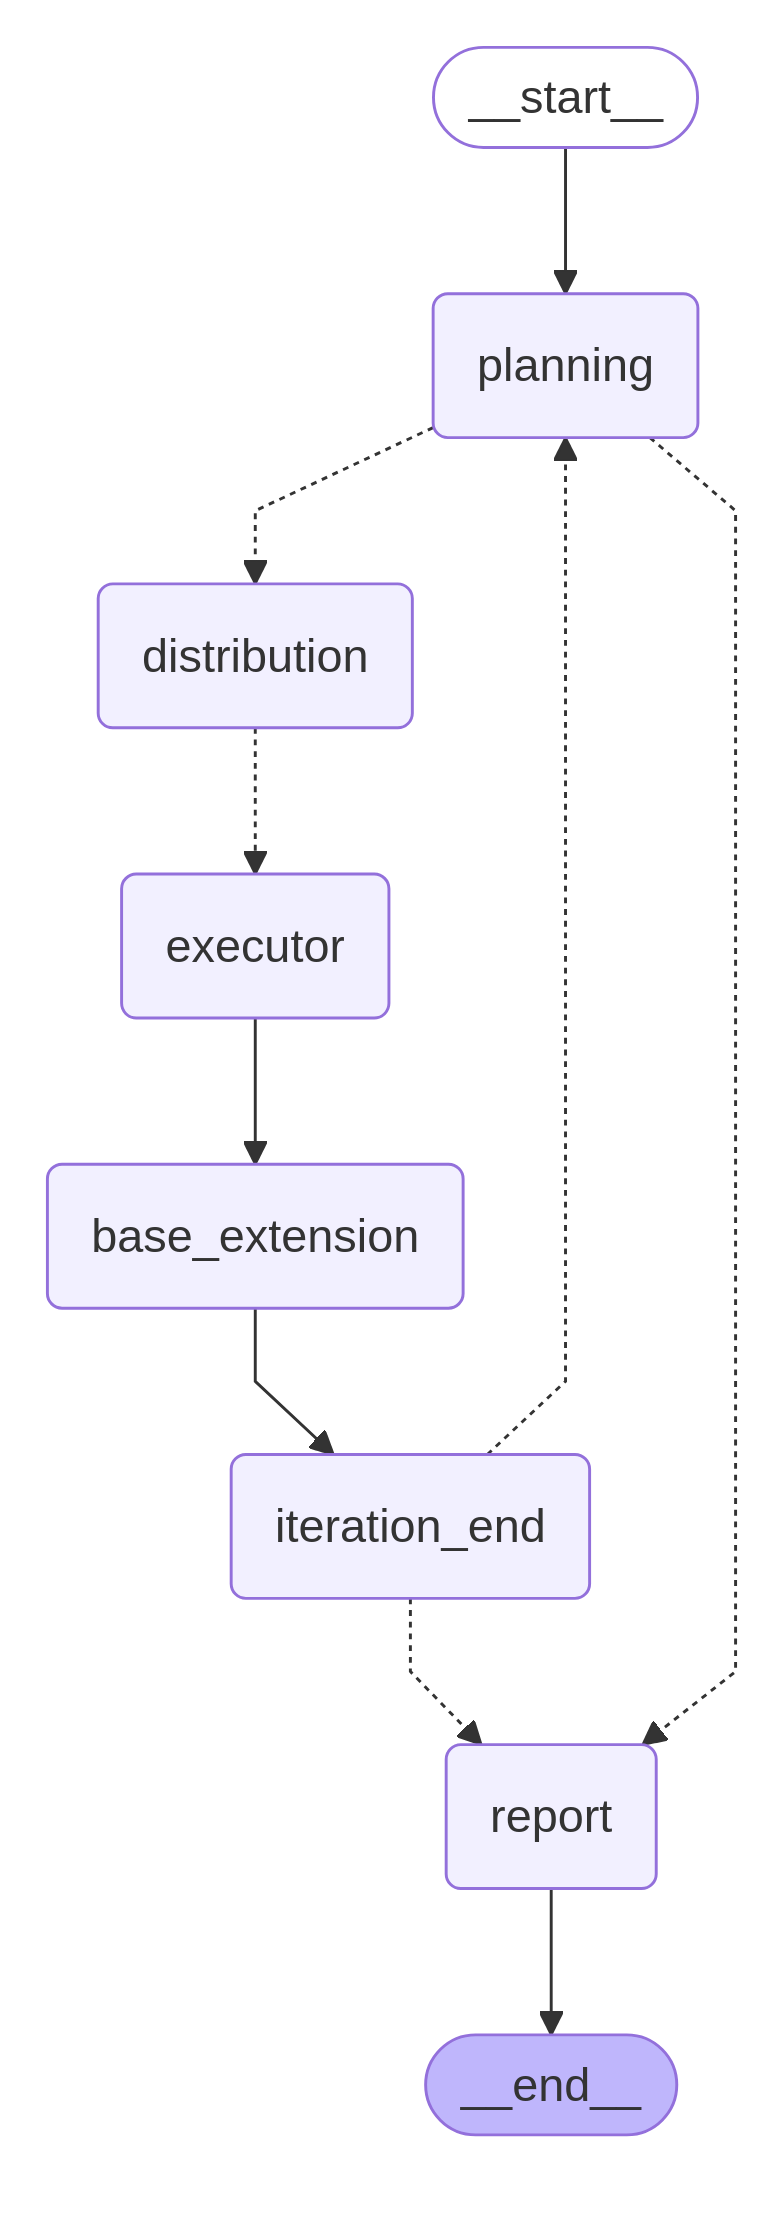

In [13]:
task_solver.display_graph()

## Real LLM

In [8]:
llm = get_llm(llm_model='google')
memory = get_checkpointer(checkpointer_mode='local', mode='test')

tool_containers = [
    PhantomResearcherSpecTool(llm=llm, memory=memory)
]

job_handler = JobHandlerSpecTool(
    llm=llm,
    tool_containers=tool_containers,
    memory=memory,
)

In [9]:
task_solver = PlannedIterativeTaskSolver(
    llm=llm,
    job_handler=job_handler,
    initial_messages_spec=PlannedIterativeTaskSolverConfig.initial_messages_spec,
    internal_messages_spec=PlannedIterativeTaskSolverConfig.internal_messages_spec,
    memory=memory,
    init_values=PlannedIterativeTaskSolverConfig.init_values,
    prompt_manager_spec=PlannedIterativeTaskSolverConfig.prompt_manager_spec,
    global_inputs=PlannedIterativeTaskSolverConfig.global_inputs
)

In [10]:
output = task_solver.run(**inputs)

# Final Report
print("\n---\nFinal Report:\n\n")
for line in output['output'].split('\n'):
    print(line)

Planning turn 1...
Jobs Distribution turn 1...
Job Execution turn 1: Research and describe core Chain-of-Thought prompting techniques, focusing on the original CoT paper and any widely recognized variations....
Job Execution turn 1: Investigate Self-Consistency Decoding in the context of Chain-of-Thought prompting. Determine if it is considered a CoT variant or an independent decoding strategy....
Job Execution turn 1: Explore Graph-based Chain-of-Thought prompting. Identify its key characteristics and how it extends the standard CoT approach....
Job Execution turn 1: Research Program-aided Chain-of-Thought prompting. Describe how programs are used to aid the reasoning process in CoT....
Job execution end
Job execution end
Job execution end
Job execution end
Base Extension turn 1...
Planning turn 2...
Process End Routing turn 2...
Jobs Distribution turn 2...
Job Execution turn 2: Determine if Self-Consistency is considered a prompting technique or primarily a decoding strategy in the c

In [11]:
# Load whole task solver state
research_state = task_solver.get_state(output['thread_id'])
#research_state

In [12]:
# All messages from the process
for msg in research_state['all_messages']:
    msg.pretty_print()

================================ System Message ================================
Name: system

# **CONVERSATION PURPOSE**

This conversation aims to:

1.  **Acquire Data**: Systematically gather all data relevant to the research's **MAIN TASK**.
2.  **Plan Strategically**: Conduct iterative research, moving from general to specific topics.
3.  **Ensure Comprehensive Output**: Continuously analyze the **MAIN TASK** description to ensure all necessary data is collected.

---

# **WORKFLOW OVERVIEW**

## **Workflow nodes**
Each node has a specific role. Focus solely on the current node's task without anticipating subsequent steps.
- Task Specification: The user provides the main task description and all necessary details.
- Analysis: Assess the current report state and formulate further research directions.
- Jobs Distribution: Based on the analysis, delegate specific research jobs to specialized agents.
- Jobs Execution: Agents execute the assigned jobs, gathering data and insights.
- Re

In [13]:
# Knowledge Base
for line in research_state['knowledge_base'].split('\n'):
    print(line)

```
<report>
Title: Introduction to Prompt Engineering
- Description: This section defines prompt engineering, explains its importance, and provides a brief overview of how Large Language Models (LLMs) work.
- Relevance: This section directly addresses the need for an introduction to prompt engineering and provides context for the rest of the guidebook, as outlined in the book specification. It also touches on how LLMs work, as requested in the initial description.

Title: Basic Prompting Techniques: Zero-Shot, One-Shot, and Few-Shot
- Description: This section covers fundamental prompting techniques, including zero-shot, one-shot, and few-shot prompting. It provides definitions, explanations of why they work, and examples.
- Relevance: This section directly addresses the requirement for a broad overview of prompt engineering techniques and a comprehensive guide from beginner to expert, as stated in the content description.

Title: Advanced Prompting Techniques: Chain-of-Thought, Tree-

In [14]:
# All delegated jobs
for i,job in enumerate(research_state['all_jobs']):
    print(f'Job {i+1}:')
    print('Job: ', job.job)
    print('Restrictions: ', job.restrictions)
    print('Output Format: ', job.output_format)
    print('Variables: ', job.variables)
    print('-'*50)

Job 1:
Job:  Research and define the core concepts of prompt engineering, its significance in the context of large language models, and briefly touch upon how LLMs work to provide context. Focus on providing a clear and concise definition suitable for both non-technical and technical readers.
Restrictions:  Avoid overly technical jargon and deep dives into LLM architecture. Target both technical and non-technical readers.
Output Format:  A definition of prompt engineering, explanation of its significance, and a brief overview of how LLMs work (no deep dive).
Variables:  ['restrictions']
--------------------------------------------------
Job 2:
Job:  Investigate and describe basic prompting techniques such as zero-shot, one-shot, and few-shot prompting. Provide formal definitions, explanations of why they work, and simple examples for each technique.
Restrictions:  Avoid industry-focused content. Keep explanations concise and easy to understand.
Output Format:  A description of each tec

## Partial execution

In [5]:
llm = get_llm(llm_model='google')
memory = get_checkpointer(checkpointer_mode='local', mode='test')

tool_containers = [
    PhantomResearcherSpecTool(llm=llm, memory=memory)
]

job_handler = JobHandlerSpecTool(
    llm=llm,
    tool_containers=tool_containers,
    memory=memory,
)

In [6]:
task_solver = PlannedIterativeTaskSolver(
    llm=llm,
    job_handler=job_handler,
    initial_messages_spec=PlannedIterativeTaskSolverConfig.initial_messages_spec,
    internal_messages_spec=PlannedIterativeTaskSolverConfig.internal_messages_spec,
    memory=memory,
    init_values=PlannedIterativeTaskSolverConfig.init_values,
    prompt_manager_spec=PlannedIterativeTaskSolverConfig.prompt_manager_spec,
    global_inputs=PlannedIterativeTaskSolverConfig.global_inputs
)

### planning

In [26]:
thread_id = 'planning1'
research_state = task_solver.graph.invoke(
            input={
                'template_inputs': inputs,
                'turns': 0,
                'knowledge_base': 'Empty'
                },
            config = {'configurable': {'thread_id': thread_id}},
            interrupt_after='planning'
        )

In [27]:
for msg in research_state['current_messages']:
    msg.pretty_print()

================================ System Message ================================
Name: system

# **CONVERSATION PURPOSE**

This conversation aims to:

1.  **Acquire Data**: Systematically gather all data relevant to the research's **MAIN TASK**.
2.  **Plan Strategically**: Conduct iterative research, moving from general to specific topics.
3.  **Ensure Comprehensive Output**: Continuously analyze the **MAIN TASK** description to ensure all necessary data is collected.

---

# **WORKFLOW OVERVIEW**

## **Workflow nodes**
Each node has a specific role. Focus solely on the current node's task without anticipating subsequent steps.
- Task Specification: The user provides the main task description and all necessary details.
- Analysis: Assess the current knowledge base and formulate further research directions.
- Jobs Distribution: Based on the analysis, delegate specific research jobs to specialized agents.
- Jobs Execution: Agents execute the assigned jobs, gathering data and insights.
- 

In [28]:
task_solver.get_state(thread_id)

{'template_inputs': {'job': 'List all Chain-of-Thought prompting variants',
  'restrictions': '\n    1. List only real prompting techniques\n    2. Do not include techniques that are just applications of other techniques\n    3. Do not include techniques that are not related to CoT prompting',
  'output_format': 'List of techniques with very short description of each technique',
  'data': 'None'},
 'turns': 1,
 'knowledge_base': 'Empty',
 'current_messages': [SystemMessage(content="# **CONVERSATION PURPOSE**\n\nThis conversation aims to:\n\n1.  **Acquire Data**: Systematically gather all data relevant to the research's **MAIN TASK**.\n2.  **Plan Strategically**: Conduct iterative research, moving from general to specific topics.\n3.  **Ensure Comprehensive Output**: Continuously analyze the **MAIN TASK** description to ensure all necessary data is collected.\n\n---\n\n# **WORKFLOW OVERVIEW**\n\n## **Workflow nodes**\nEach node has a specific role. Focus solely on the current node's tas

### jobs distribution

In [38]:
thread_id = 'distribution1'
research_state = task_solver.graph.invoke(
            input={
                'template_inputs': inputs,
                'turns': 0,
                'knowledge_base': 'Empty'
                },
            config = {'configurable': {'thread_id': thread_id}},
            interrupt_after='distribution'
        )

Planning turn 1...
Jobs Distribution turn 1...


In [39]:
for msg in research_state['current_messages']:
    msg.pretty_print()

================================ System Message ================================
Name: system

# **CONVERSATION PURPOSE**

This conversation aims to:

1.  **Acquire Data**: Systematically gather all data relevant to the research's **MAIN TASK**.
2.  **Plan Strategically**: Conduct iterative research, moving from general to specific topics.
3.  **Ensure Comprehensive Output**: Continuously analyze the **MAIN TASK** description to ensure all necessary data is collected.

---

# **WORKFLOW OVERVIEW**

## **Workflow nodes**
Each node has a specific role. Focus solely on the current node's task without anticipating subsequent steps.
- Task Specification: The user provides the main task description and all necessary details.
- Analysis: Assess the current knowledge base and formulate further research directions.
- Jobs Distribution: Based on the analysis, delegate specific research jobs to specialized agents.
- Jobs Execution: Agents execute the assigned jobs, gathering data and insights.
- 

In [40]:
for i,job in enumerate(research_state['current_jobs']):
    print(f'Job {i+1}:')
    print(job.job)
    print(job.restrictions)
    print(job.output_format)
    print(job.variables)
    print('-'*50)

Job 1:
Research and summarize the Chain-of-Thought (CoT) prompting technique, including its core principles and variations.
Focus on the prompting technique itself, not its applications. Adhere to the general restrictions.
A short description of the technique.
['restrictions']
--------------------------------------------------
Job 2:
Investigate and summarize Self-Consistency and Least-to-Most Prompting as Chain-of-Thought variants.
Focus on the prompting techniques themselves, not their applications. Adhere to the general restrictions.
Short descriptions of each technique, highlighting their differences and similarities.
['restrictions']
--------------------------------------------------
Job 3:
Research and summarize Tree-of-Thoughts (ToT) and Graph of Thoughts (GoT) prompting techniques.
Focus on the prompting techniques themselves, not their applications. Adhere to the general restrictions.
Short descriptions of each technique, highlighting their differences and similarities.
['rest

### knowledge extension

In [7]:
thread_id = 'base_extension1'
research_state = task_solver.graph.invoke(
            input={
                'template_inputs': inputs,
                'turns': 0,
                'knowledge_base': 'Empty'
                },
            config = {'configurable': {'thread_id': thread_id}},
            interrupt_after='base_extension'
        )

Planning turn 1...
Jobs Distribution turn 1...


In [8]:
for msg in research_state['current_messages']:
    msg.pretty_print()

================================ System Message ================================
Name: system

# **CONVERSATION PURPOSE**

This conversation aims to:

1.  **Acquire Data**: Systematically gather all data relevant to the research's **MAIN TASK**.
2.  **Plan Strategically**: Conduct iterative research, moving from general to specific topics.
3.  **Ensure Comprehensive Output**: Continuously analyze the **MAIN TASK** description to ensure all necessary data is collected.

---

# **WORKFLOW OVERVIEW**

## **Workflow nodes**
Each node has a specific role. Focus solely on the current node's task without anticipating subsequent steps.
- Task Specification: The user provides the main task description and all necessary details.
- Analysis: Assess the current knowledge base and formulate further research directions.
- Jobs Distribution: Based on the analysis, delegate specific research jobs to specialized agents.
- Jobs Execution: Agents execute the assigned jobs, gathering data and insights.
- 